# Compare Representational Similarities

## Import Necessarly Libraries

In [172]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))
import torchvision
import PIL
import lightly
import torch
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import tqdm
import logging
import rsatoolbox as rsa
import pytorch_lightning as pl
from matplotlib import pyplot as plt
from torchvision.models import alexnet
from lightly.models.modules.heads import SimCLRProjectionHead
from lightly.loss import NTXentLoss

## Get Data

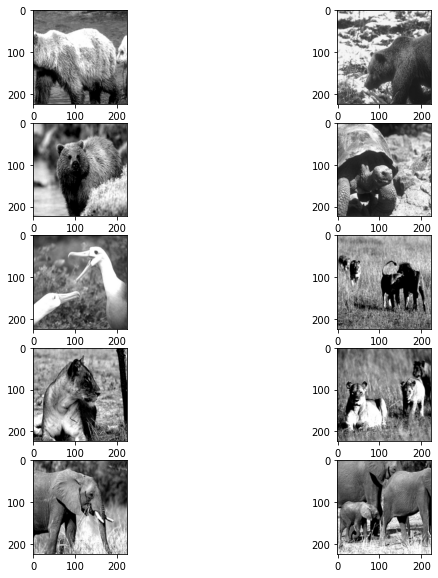

In [74]:
class NaturalScenes(torch.utils.data.Dataset):
    def __init__(self,file_path = os.path.join('DeepMouseTrap/neural_data/brain_observatory','stimulus_set.npy'),im_size=64):
        self.ims = np.load(file_path)
        self.size = 118
        self.transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),torchvision.transforms.Resize([256]),torchvision.transforms.CenterCrop(224),torchvision.transforms.Resize([im_size,im_size])])
    def __len__(self):
        return self.size
    def __getitem__(self, index):
        im = PIL.Image.fromarray(self.ims[index])
        im = self.transform(im)
        #im += 1e-1*np.random.normal(size=im.shape)
        im = im.unsqueeze(0)
        return im
stimulus = NaturalScenes(im_size=224)
fig,axs = plt.subplots(5,2,figsize=(10,10))
im=0
for i in range(5):
    for j in range(2):
        image = stimulus[im].squeeze(0).permute(1,2,0)
        axs[i,j].imshow(image)
        im+=1

In [109]:
class SimCLRModel(pl.LightningModule):
    def __init__(self):
        super().__init__()

        AlexNet = alexnet()
        self.backbone = torch.nn.Sequential(*list(AlexNet.children())[:-1])
        #print(self.backbone)
        hidden_dim = 9216
        self.projection_head = SimCLRProjectionHead(hidden_dim, hidden_dim, 128)

        self.criterion = NTXentLoss(temperature=0.1)

    def forward(self, x):
        h=self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(h)
        return z

    def training_step(self, batch, batch_idx):
        (x0, x1), _, _ = batch
        z0 = self.forward(x0)
        z1 = self.forward(x1)
        loss = self.criterion(z0, z1)
        self.log("train_loss_ssl", loss)
        return loss

    def configure_optimizers(self):
        optim = LARS(params=self.parameters(),lr=1e-2,momentum=0.9,weight_decay=1e-6)
        #scheduler = LinearWarmupCosineAnnealingLR(optimizer = optim,warmup_epochs=10,max_epochs=200)
        return [optim]#, [scheduler]
    
    def train_dataloader(self):
        collate_fn = lightly.data.SimCLRCollateFunction(input_size=64,gaussian_blur=0.0)
        return DataLoader(
                        lightly.data.LightlyDataset('../datasets/ImageNet64/train/'),
                        batch_size=512,
                        shuffle=True,
                        collate_fn=collate_fn,
                        drop_last=True,
                        num_workers=8,
                        pin_memory=False
                    )

## Define Necessary Functions

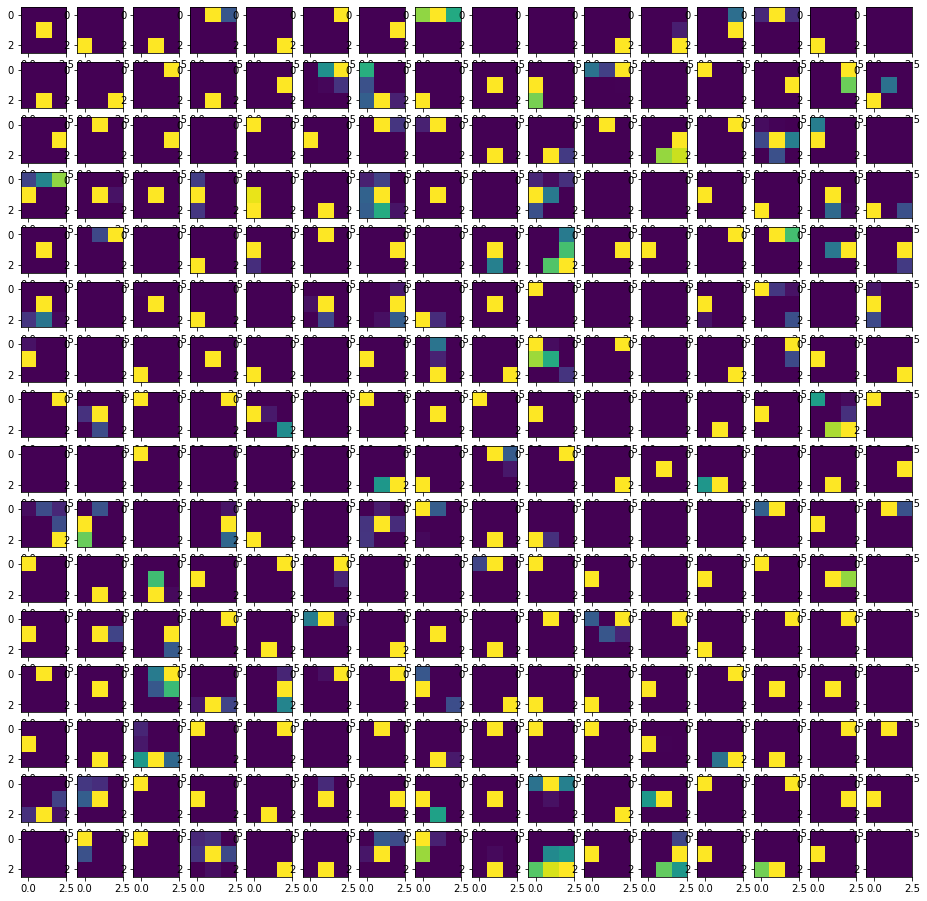

In [466]:
LAYER_MAPPING = {2:'conv1',5:'conv2',8:'conv3',10:'conv4',12:'conv5'}
DOMAINS = ['sketch','infograph','clipart','quickdraw','paint','real']
def extract_model_response(model=alexnet(pretrained=True).features, stimulus = NaturalScenes(im_size=224)):
    model_activations = {layer:[] for layer in LAYER_MAPPING.values()}
    for ind,layer in LAYER_MAPPING.items():
        activation_model=model[:ind]
        activation_model.eval()
        activations = []
        for j in range(len(stimulus)):
            # print(stimulus[j].shape)
            activation = activation_model(stimulus[j])
            # print(activation.shape)
            activations.append(activation.detach().numpy().squeeze(axis=0))
            # break
        activations = np.stack(activations)
        model_activations[layer]=activations
    return model_activations #{layer:np.stack(activations) for layer,activations in model_activations.items()}
model = SimCLRModel().load_from_checkpoint(f'../train_simclr/rep_data/temp/checkpoints/last.ckpt').backbone[0]
model_activations = extract_model_response(model,stimulus=NaturalScenes(im_size=64))
fig,axs = plt.subplots(16,16,figsize=(16,16))
conv_filter = 0
for i in range(16):
    for j in range(16):
        axs[i,j].imshow(np.transpose(model_activations['conv5'],(0,2,3,1))[0,:,:,conv_filter])
        conv_filter+=1

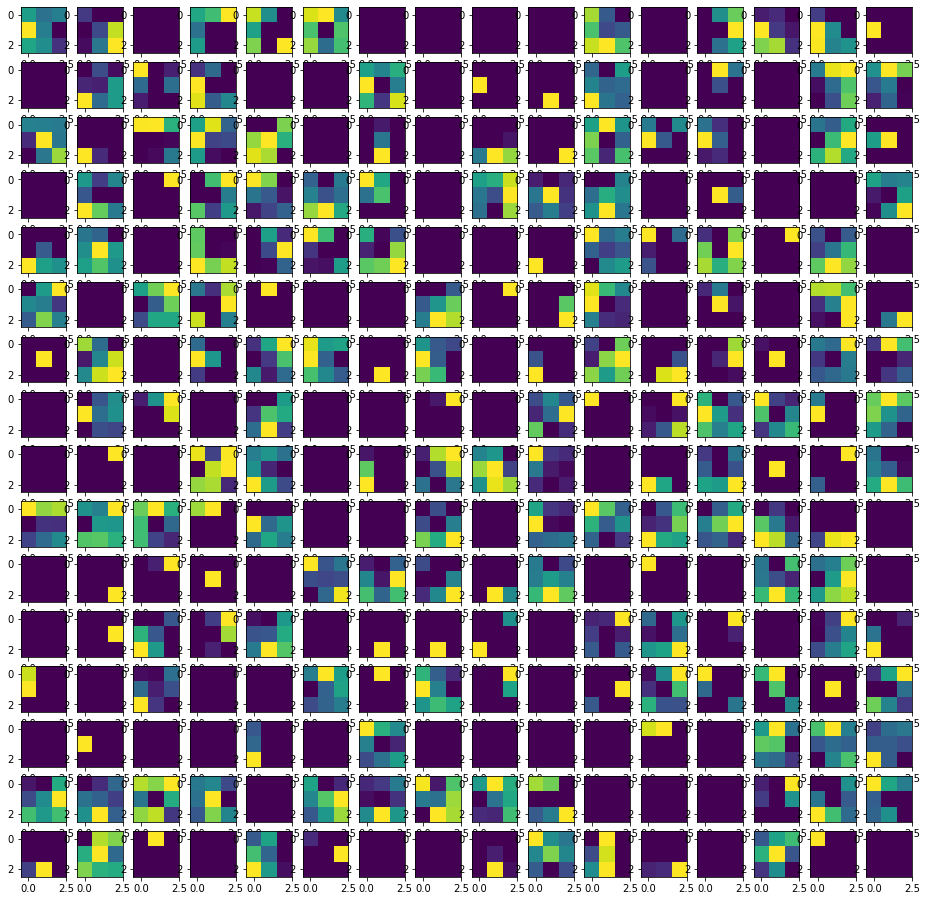

In [164]:
model = SimCLRModel().load_from_checkpoint(f'../train_simclr/rep_data/sketch2/checkpoints/last.ckpt').backbone[0]
model_activations = extract_model_response(model,stimulus=NaturalScenes(im_size=64))
fig,axs = plt.subplots(16,16,figsize=(16,16))
conv_filter = 0
for i in range(16):
    for j in range(16):
        axs[i,j].imshow(np.transpose(model_activations['conv5'],(0,2,3,1))[0,:,:,conv_filter])
        conv_filter+=1

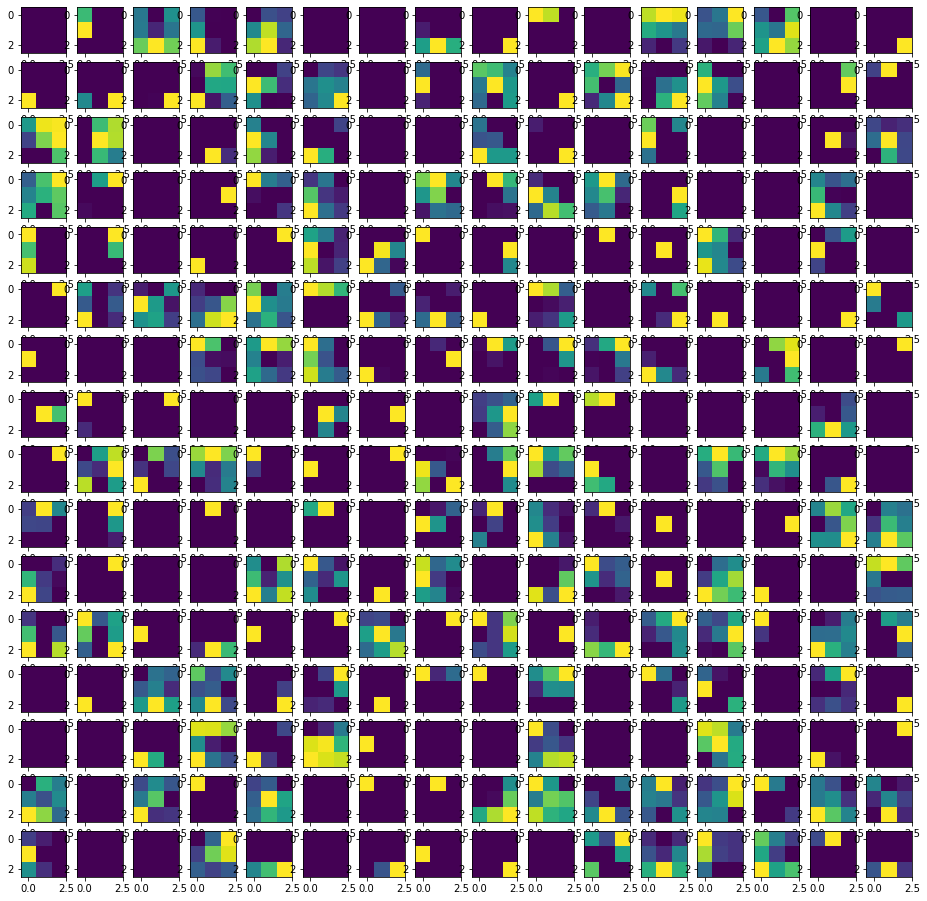

In [165]:
model = SimCLRModel().load_from_checkpoint(f'../train_simclr/rep_data/paint2/checkpoints/last.ckpt').backbone[0]
model_activations = extract_model_response(model,stimulus=NaturalScenes(im_size=64))
fig,axs = plt.subplots(16,16,figsize=(16,16))
conv_filter = 0
for i in range(16):
    for j in range(16):
        axs[i,j].imshow(np.transpose(model_activations['conv5'],(0,2,3,1))[0,:,:,conv_filter])
        conv_filter+=1

IndexError: index 64 is out of bounds for axis 3 with size 64

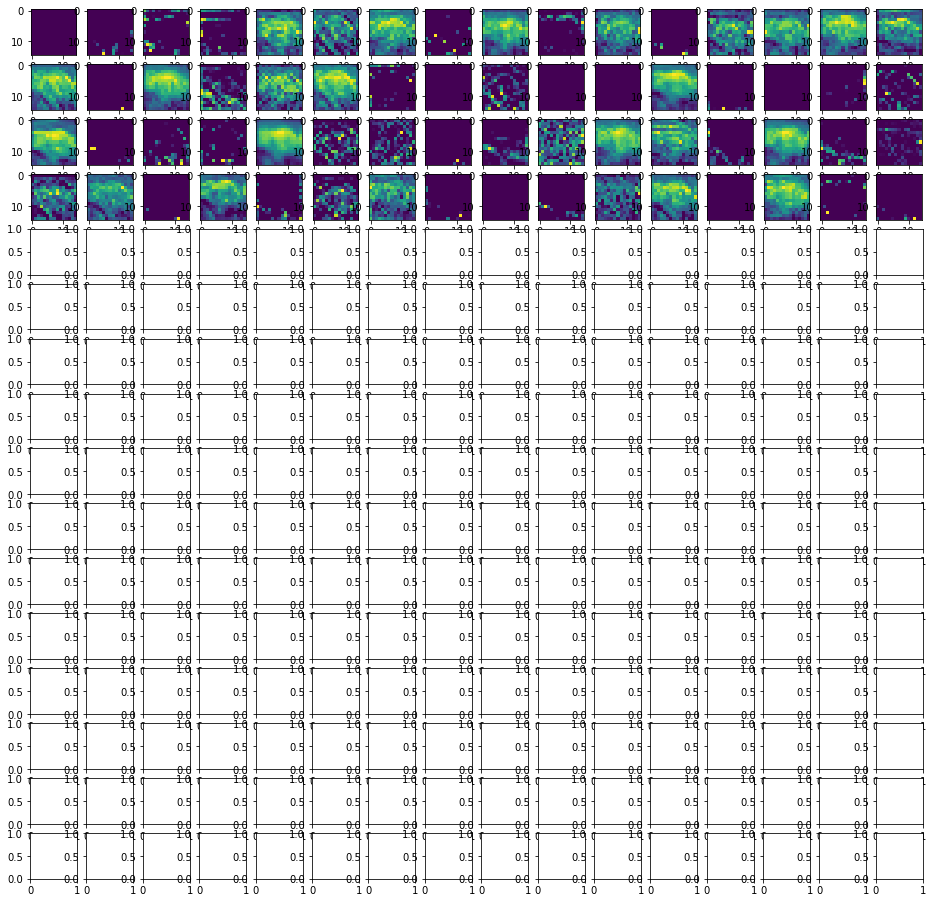

In [193]:
model = SimCLRModel().load_from_checkpoint(f'../train_simclr/rep_data/infograph2/checkpoints/last.ckpt').backbone[0]
model_activations = extract_model_response(model,stimulus=NaturalScenes(im_size=64))
fig,axs = plt.subplots(16,16,figsize=(16,16))
conv_filter = 0
for i in range(16):
    for j in range(16):
        axs[i,j].imshow(np.transpose(model_activations['conv1'],(0,2,3,1))[0,:,:,conv_filter])
        conv_filter+=1

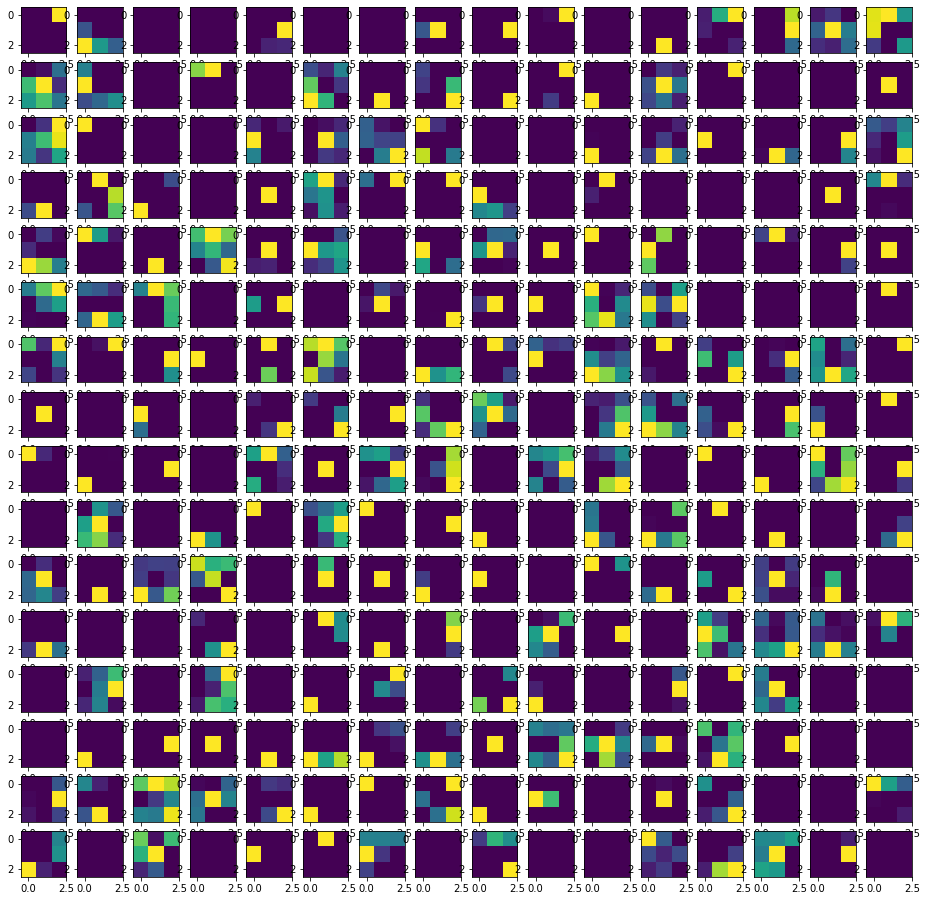

In [167]:
model = SimCLRModel().load_from_checkpoint(f'../train_simclr/rep_data/quickdraw2/checkpoints/last.ckpt').backbone[0]
model_activations = extract_model_response(model,stimulus=NaturalScenes(im_size=64))
fig,axs = plt.subplots(16,16,figsize=(16,16))
conv_filter = 0
for i in range(16):
    for j in range(16):
        axs[i,j].imshow(np.transpose(model_activations['conv5'],(0,2,3,1))[0,:,:,conv_filter])
        conv_filter+=1

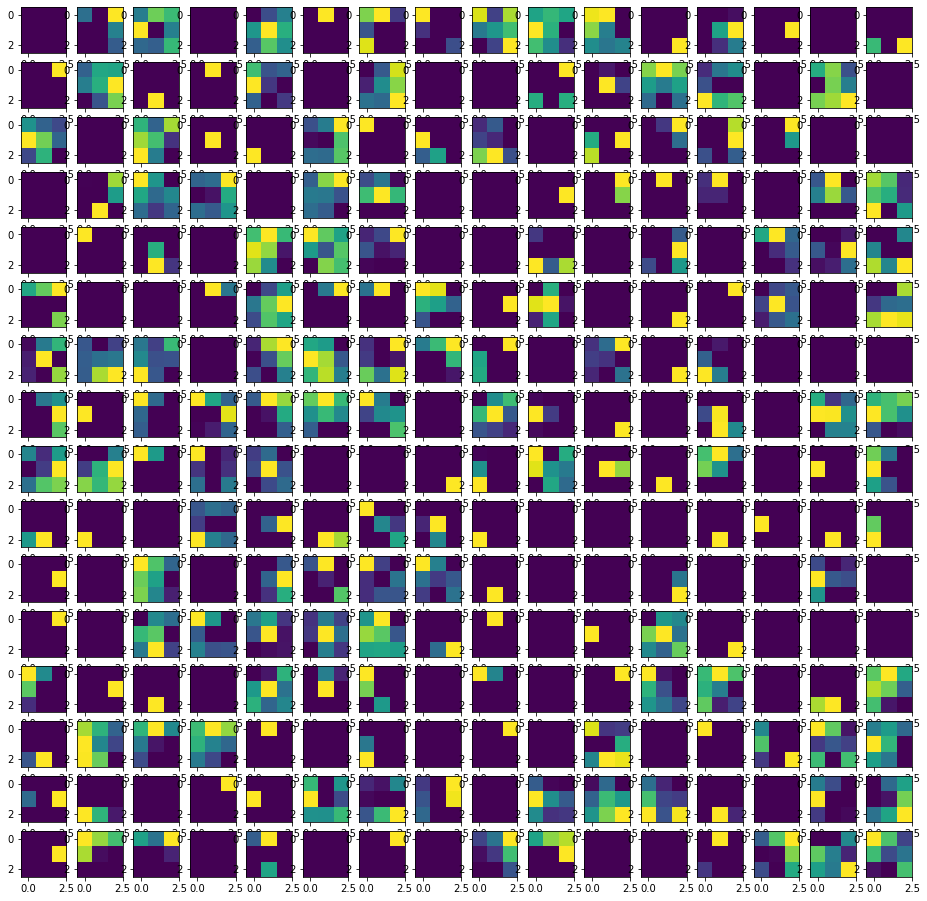

In [168]:
model = SimCLRModel().load_from_checkpoint(f'../train_simclr/rep_data/clipart2/checkpoints/last.ckpt').backbone[0]
model_activations = extract_model_response(model,stimulus=NaturalScenes(im_size=64))
fig,axs = plt.subplots(16,16,figsize=(16,16))
conv_filter = 0
for i in range(16):
    for j in range(16):
        axs[i,j].imshow(np.transpose(model_activations['conv5'],(0,2,3,1))[0,:,:,conv_filter])
        conv_filter+=1

(6, 1699200)


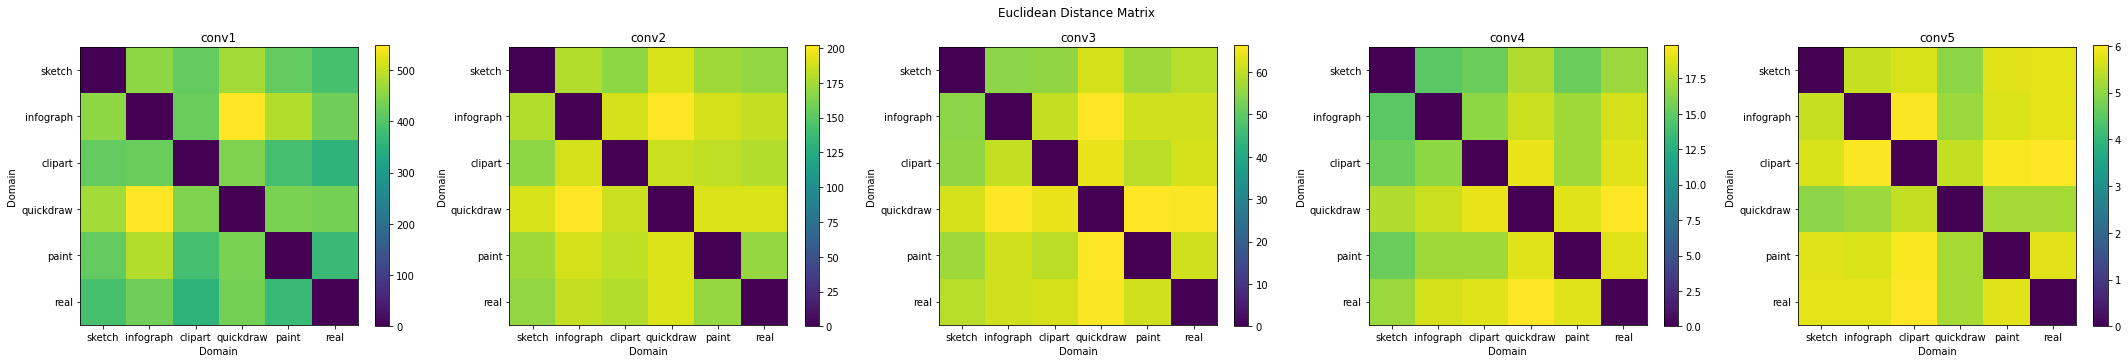

In [488]:
from scipy.spatial.distance import pdist,squareform
fig,axs=plt.subplots(1,5,figsize=(30,5),facecolor='white')
dist_matrices = {}
activation_matrices = {layer:[] for layer in LAYER_MAPPING.values()}
for domain in DOMAINS:
    model = SimCLRModel().load_from_checkpoint(f'../train_simclr/rep_data/{domain}2/checkpoints/last.ckpt')
    activations = extract_model_response(model.backbone[0],stimulus=NaturalScenes(im_size=64))
    for layer in activations.keys():
        activation_matrices[layer].append(activations[layer].flatten())
activation_matrices = {layer:np.stack(activations) for layer,activations in activation_matrices.items()}
print(activation_matrices['conv1'].shape)
dist_matrices = {layer:squareform(pdist(val_matrix,metric='euclidean')) for layer, val_matrix in activation_matrices.items()}
j=1
for layer,dist_matrix in dist_matrices.items():
    plot = axs[j-1].imshow(dist_matrix)
    plt.colorbar(plot,ax=axs[j-1],shrink=0.925)
    axs[j-1].set_xticks(ticks=np.arange(0,6,1))
    axs[j-1].set_xticklabels(DOMAINS)
    axs[j-1].set_yticks(ticks=np.arange(0,6,1))
    axs[j-1].set_yticklabels(DOMAINS)
    axs[j-1].set_title(layer)
    axs[j-1].set_xlabel("Domain")
    axs[j-1].set_ylabel("Domain")
    j+=1
#cbar_ax = fig.add_axes([0.75, 0.15, 0.05, 0.6])
fig.suptitle("Euclidean Distance Matrix")
#fig.colorbar(plot, cax=cbar_ax)
fig.tight_layout()
plt.show()

### Test

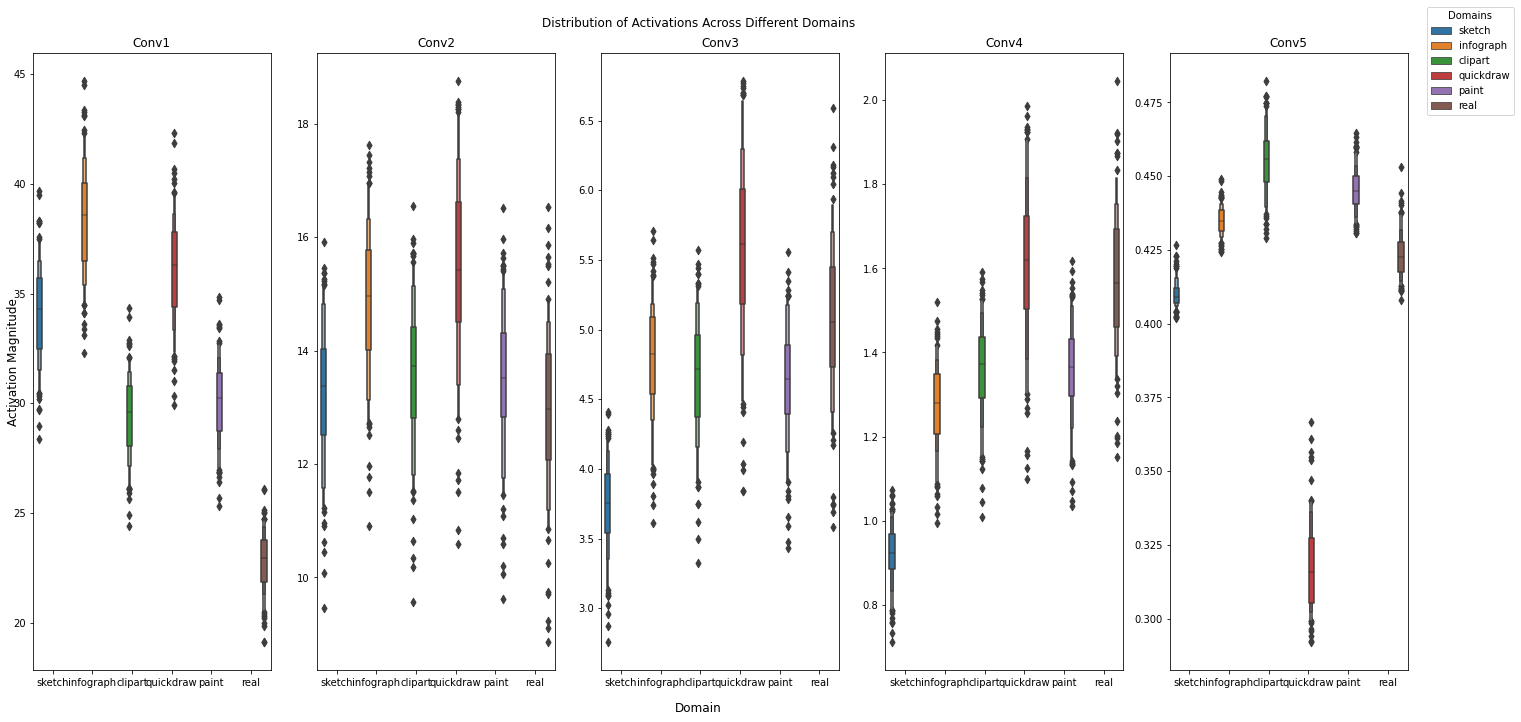

In [160]:
domain_dists = {'sketch':None,'infograph':None,'clipart':None,'quickdraw':None,'paint':None,'real':None}
for domain in domain_dists.keys():
    model = SimCLRModel().load_from_checkpoint(f'../train_simclr/rep_data/{domain}2/checkpoints/last.ckpt')
    activations = extract_model_response(model.backbone[0],stimulus=NaturalScenes(im_size=64))
    layer_dists = {layer:None for layer in LAYER_MAPPING.values()}
    for layer in LAYER_MAPPING.values():
        layer_dists[layer]=pd.DataFrame(torch.norm(torch.Tensor(activations[layer]),p=2,dim=(1,2,3)),columns=['Activation Magnitude'])
    layer_dists = pd.concat([layer_dists[layer].assign(Layer=layer) for layer in layer_dists.keys()])
    domain_dists[domain]=layer_dists
domain_dists = pd.concat([df.assign(Domain=domain) for domain,df in domain_dists.items()])
domain_dists.head()
fig,axs = plt.subplots(1,5,figsize=(20,10),facecolor="white")
for i in range(1,6):
    layer_dist = domain_dists[domain_dists["Layer"]==f'conv{i}']
    plot = sns.boxenplot(data=domain_dists[domain_dists["Layer"]==f'conv{i}'],x="Domain",y="Activation Magnitude",hue="Domain",ax=axs[i-1])
    plot.set(title=f'Conv{i}',xlabel=None,ylabel=None)
    plot.get_legend().remove()
fig.suptitle("Distribution of Activations Across Different Domains")
fig.supxlabel("Domain")
fig.supylabel("Activation Magnitude")
fig.tight_layout()
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

# finally we invoke the legend (that you probably would like to customize...)

fig.legend(lines[:6], labels[:6],loc='upper right',bbox_to_anchor=(1.07,1),title='Domains')
plt.show()